maxcor


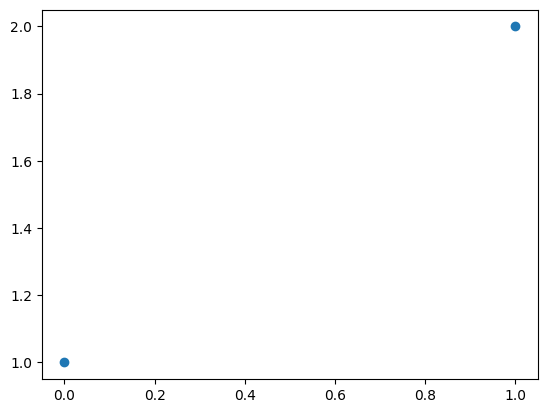

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_test
import cupy as cp
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

10000
Style_A


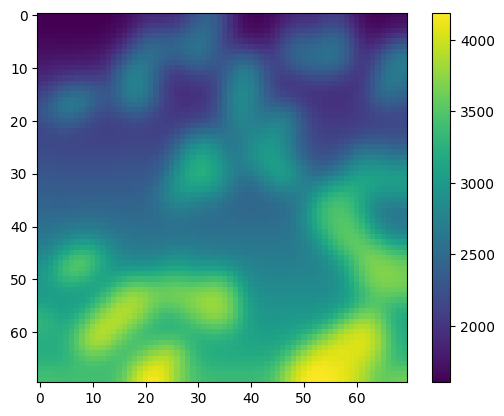

In [2]:
importlib.reload(kgs)
importlib.reload(seis_test)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()
d = data[8000]
print(d.family)
d.load_to_memory()
plt.figure()
plt.imshow(cp.asnumpy(d.velocity.data));plt.colorbar();#plt.clim([-3,3])
import seis_test
#seis_test.test_stuff_on_one_case(d,1e-4)
d.load_to_memory()

In [3]:
# importlib.reload(seis_forward)
# seis_forward.vel_to_seis_J_file(d.velocity, kgs.temp_dir + 'J')

In [4]:
def matmul_efficient(A,B):
    out = cp.zeros((A.shape[0],B.shape[1]), dtype=A.dtype)
    sub_list = np.array_split(np.arange(A.shape[1]), 49)
    for inds in sub_list:
        #print(len(inds))
        out += cp.matmul(A[:,inds],B[inds,:])
    return out
def matmul_part_cpu(A,B):
    out = cp.array(A@cp.asnumpy(B))
    return out
    

In [5]:
importlib.reload(seis_forward)
J = seis_forward.vel_to_seis_J_load_file(kgs.temp_dir + 'J_64_', to_cpu=True)

In [6]:
# JTJ = cp.array(np.transpose(J)@J)
# print(JTJ.dtype)
# JTJ = JTJ/2+cp.transpose(JTJ)/2
# kgs.dill_save(kgs.temp_dir + 'JTJ', JTJ)
JTJ = kgs.dill_load(kgs.temp_dir + 'JTJ')

In [7]:
import seis_prior
import seis_forward2
import seis_invert
import cupyx.scipy.linalg
importlib.reload(seis_prior)
kgs.profiling=False
kgs.debugging_mode = 0
seis_forward2.profiling=False
seis_forward2.reset_profile()

# transform back on, history size to infinite, maxiter down
model = seis_invert.InversionModel()
model.state = 1
model.maxiter = 3000
model.history_size = 10000
model.prior = seis_prior.SquaredExponential()
model.prior.transform = False
model.prior.svd_cutoff = 1.
model.prior.λ = 10**-11

model.prior.basis_functions()
P = model.prior.P
P = cupyx.scipy.linalg.block_diag(P, cp.eye(1,dtype=P.dtype))

False False
(4901, 4901)


In [8]:
def show_mat(X,T):
    eigs,eig_vectors = cp.linalg.eigh(X)   
    plt.figure()
    plt.semilogy(cp.asnumpy(cp.abs(eigs)))
    for ii in [0,2000,4900]:
        plt.figure()
        plt.imshow(cp.asnumpy(cp.reshape((T@eig_vectors[:,ii:ii+1])[:-1],(70,70))))
        plt.title(ii)

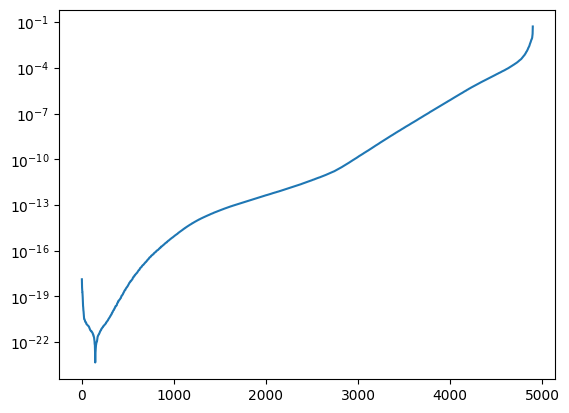

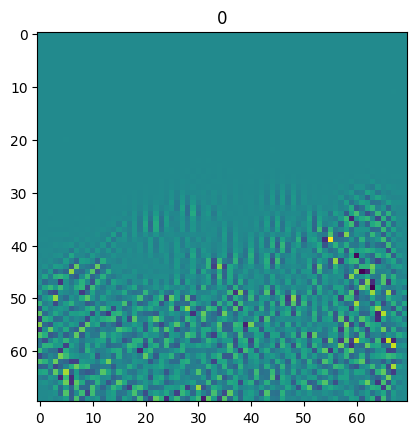

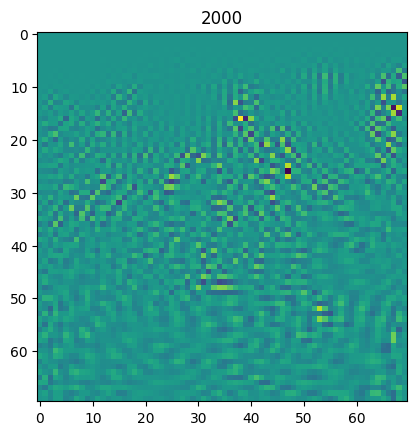

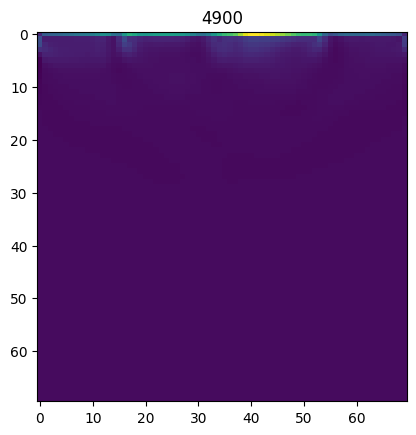

In [9]:
show_mat(JTJ,cp.eye(4901))

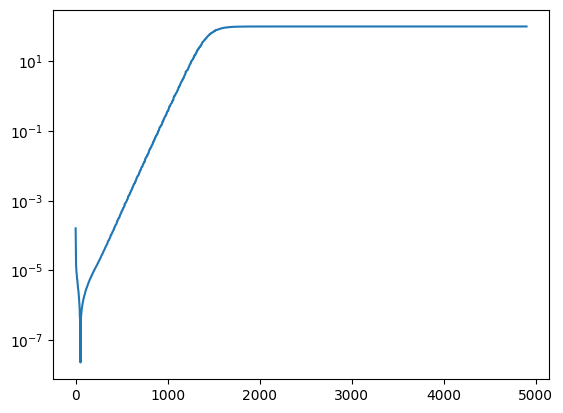

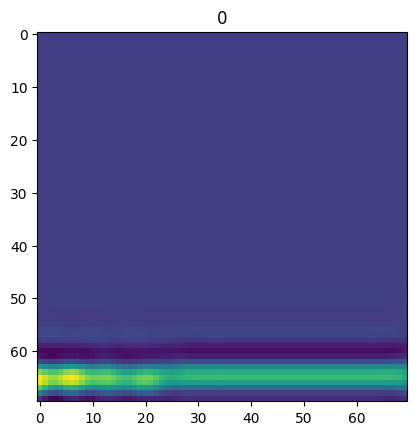

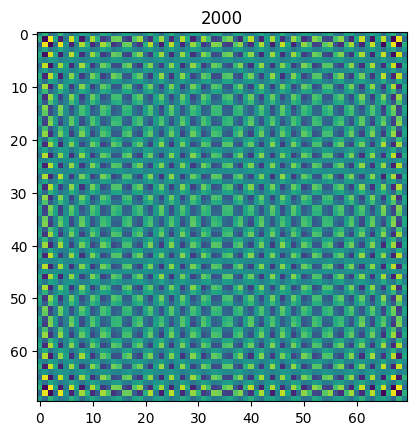

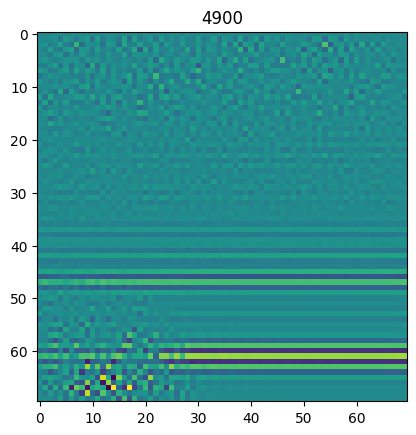

In [10]:
show_mat(P,cp.eye(4901))

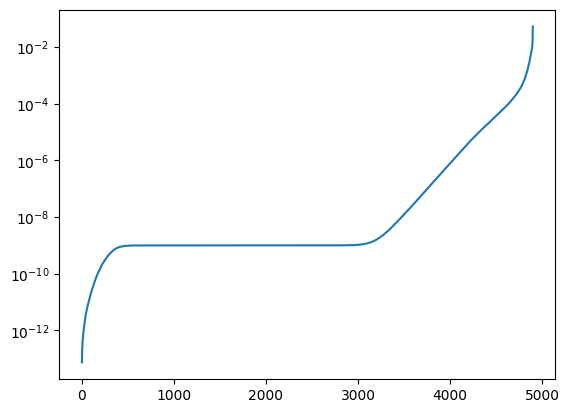

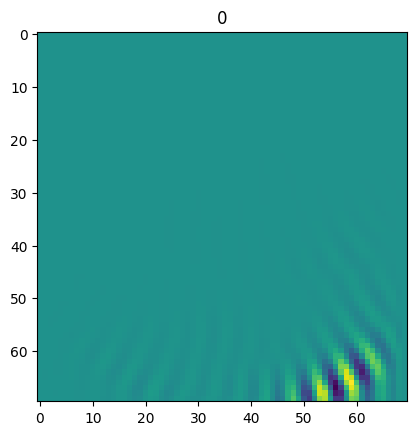

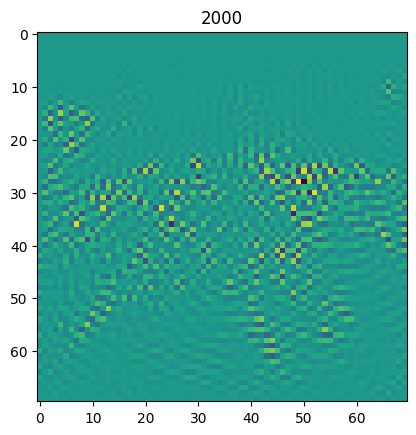

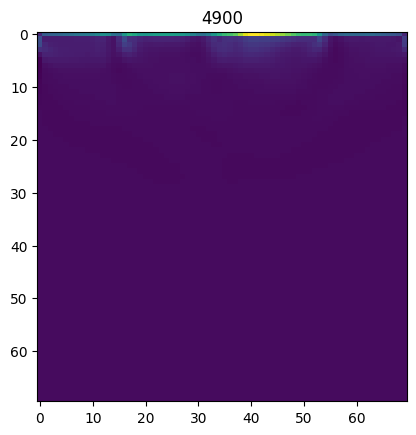

In [11]:
show_mat(10**-11*P+JTJ,cp.eye(4901)) 

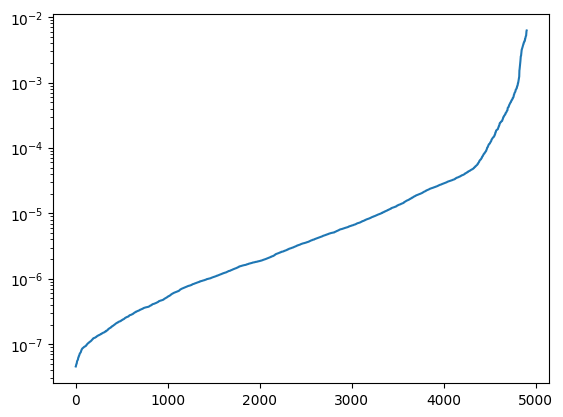

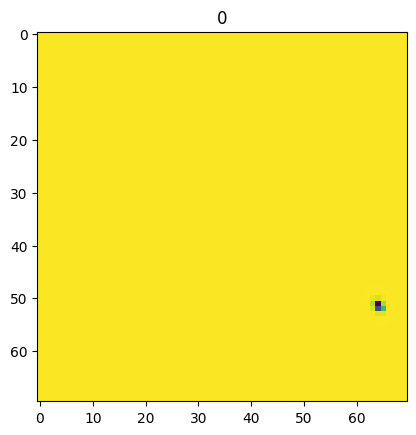

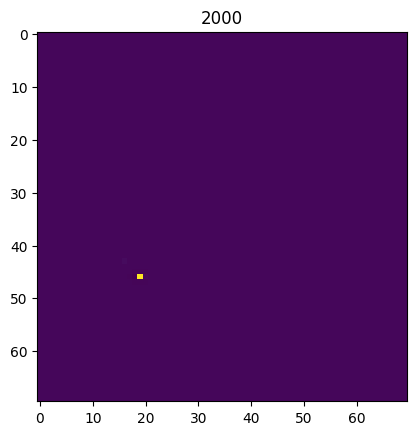

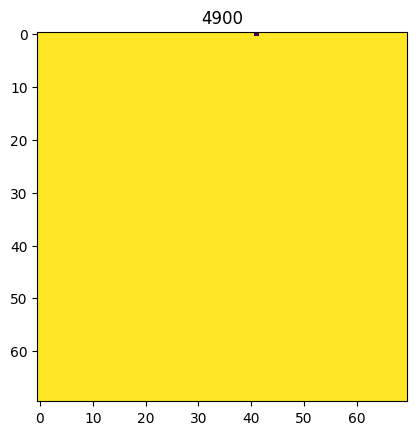

In [12]:
show_mat(10**-11*P+cp.diag(cp.diag(JTJ)),cp.eye(4901)) 

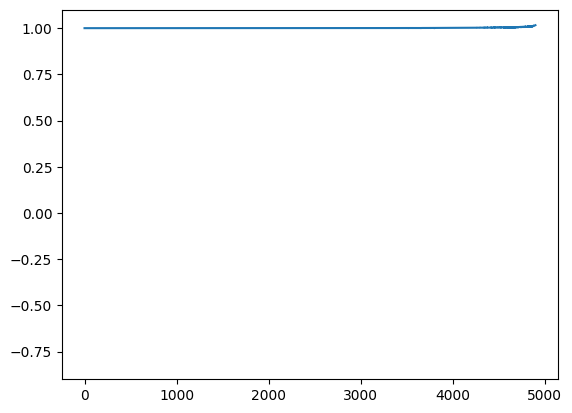

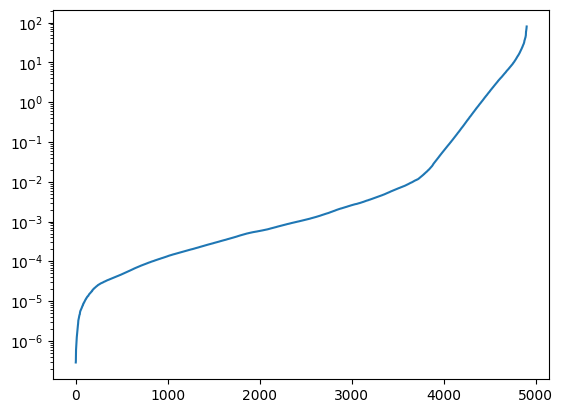

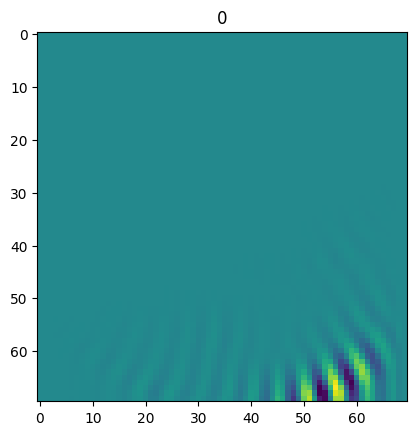

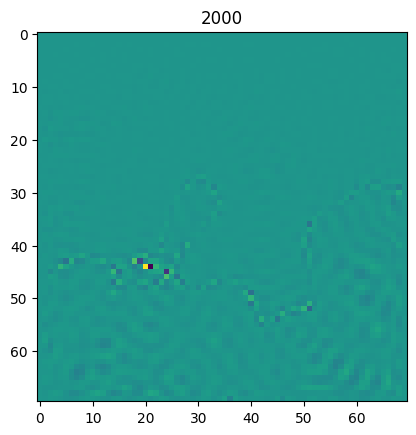

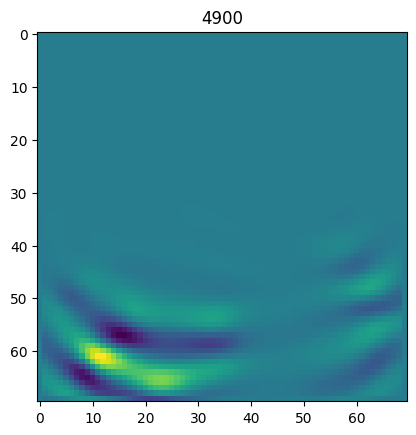

In [13]:
X=10**-11*P+JTJ
U,s,_=cp.linalg.svd(cp.diag(cp.diag(JTJ)),compute_uv=True)
L = U@cp.diag(1/cp.sqrt(s))
plt.figure();plt.plot(cp.asnumpy(cp.diag(L.T@(X)@L)));plt.ylim([-0.9,1.1])
show_mat(L.T@(X)@L,L)

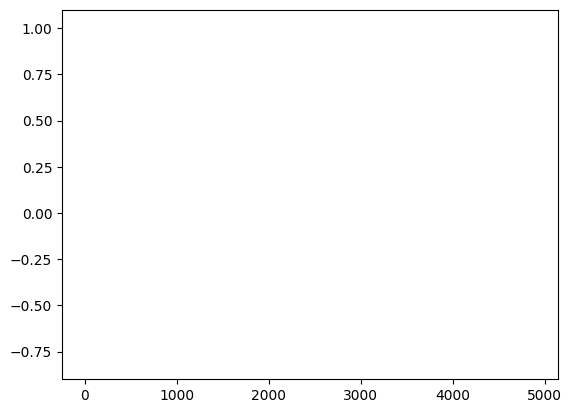

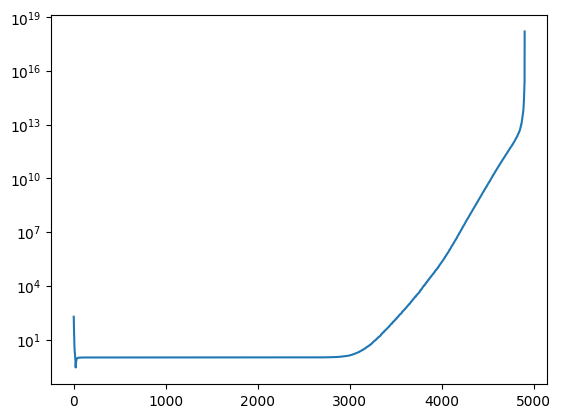

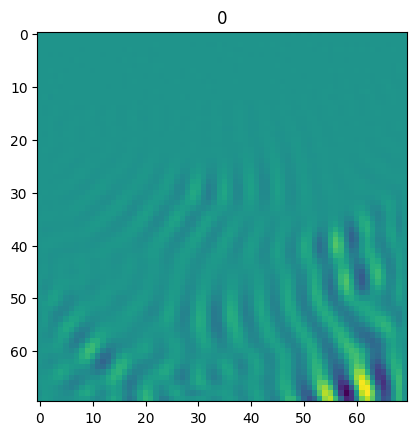

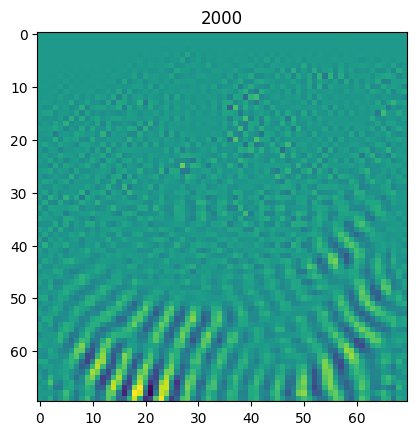

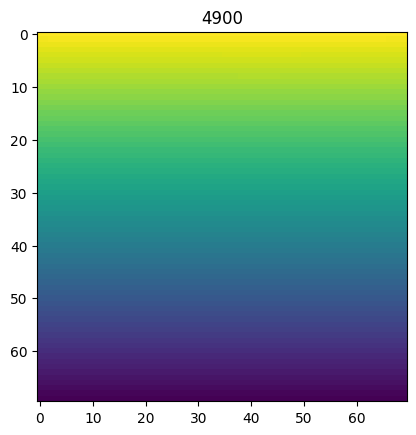

In [14]:
X=10**-11*P+JTJ
U,s,_=cp.linalg.svd(10**-11*P,compute_uv=True)
L = U@cp.diag(1/cp.sqrt(s))
plt.figure();plt.plot(cp.asnumpy(cp.diag(L.T@(X)@L)));plt.ylim([-0.9,1.1])
show_mat(L.T@(X)@L,L)

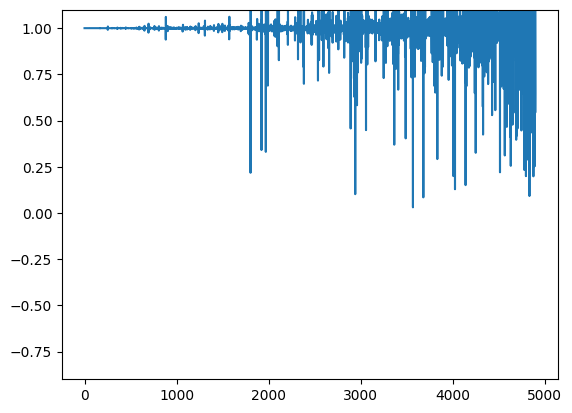

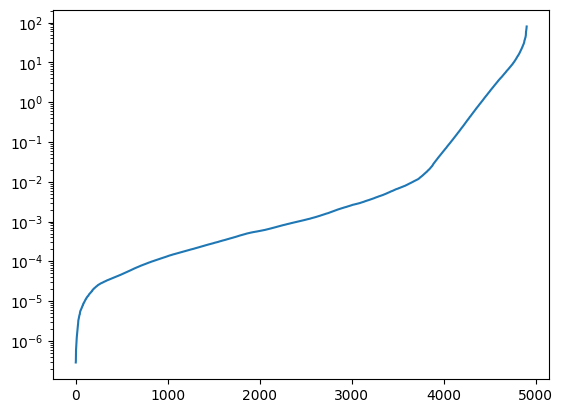

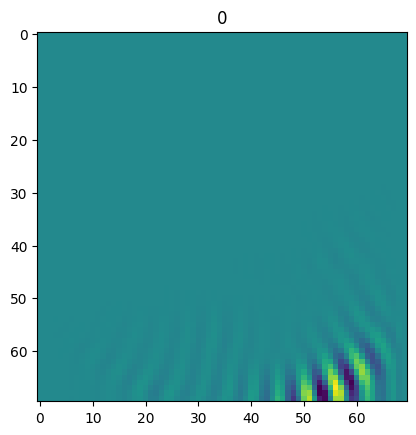

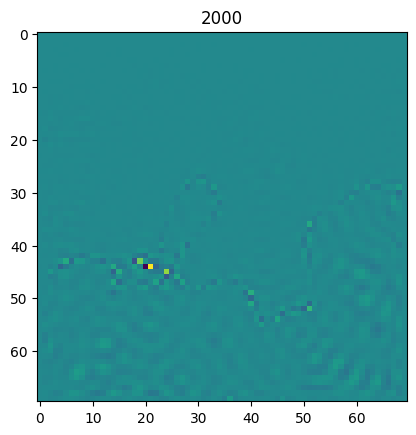

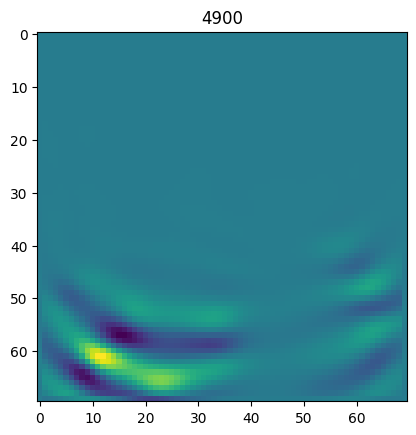

In [15]:
X=10**-11*P+JTJ
U,s,_=cp.linalg.svd(10**-11*P+cp.diag(cp.diag(JTJ)),compute_uv=True)
L = U@cp.diag(1/cp.sqrt(s))
plt.figure();plt.plot(cp.asnumpy(cp.diag(L.T@(X)@L)));plt.ylim([-0.9,1.1])
show_mat(L.T@(X)@L,L)

In [110]:
import seis_nn
vel_true = d.velocity
seis_given = d.seismogram
seis_given.from_vector(seis_forward2.vel_to_seis(vel_true.to_vector())[0])
vel_guess = seis_nn.default_pretrained.infer([d])[0].velocity_guess
vel_guess_cp = copy.deepcopy(vel_guess)
vel_guess_cp.data = cp.array(vel_guess_cp.data,dtype=kgs.base_type_gpu)
vel_guess_cp.min_vel = cp.array(vel_guess_cp.min_vel,dtype=kgs.base_type_gpu)
vel_guess_cp.from_vector(0.0001*vel_guess_cp.to_vector()+0.9999*vel_true.to_vector())
vel_true_np = copy.deepcopy(vel_true)
vel_true_np.data = cp.asnumpy(vel_true.data)

seis_remodeled = copy.deepcopy(seis_given)
seis_remodeled.from_vector(seis_forward2.vel_to_seis(vel_guess_cp.to_vector())[0])



In [115]:
lam=10**-22
rhs = matmul_part_cpu(J.T,seis_given.to_vector()-seis_remodeled.to_vector())-lam*P@vel_true.to_vector()
sol = cp.linalg.solve(lam*P+JTJ,rhs)
kgs.rms( (vel_guess_cp.to_vector()+sol) - vel_true.to_vector() ), kgs.rms( (vel_guess_cp.to_vector()) - vel_true.to_vector() )

(array(0.03185292), array(0.00546735))

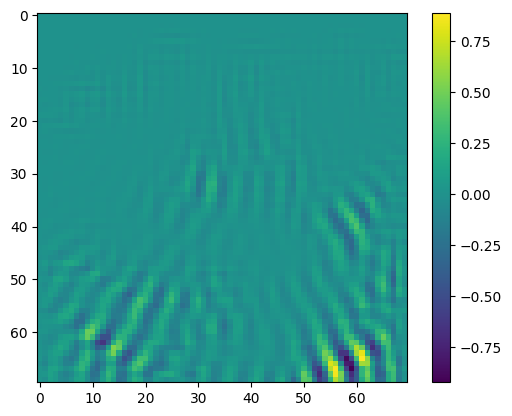

In [96]:
plt.figure()
vel_res = copy.deepcopy(vel_guess_cp)
vel_res.from_vector(vel_guess_cp.to_vector()+sol- vel_true.to_vector())
plt.imshow(cp.asnumpy(vel_res.data))
plt.colorbar()

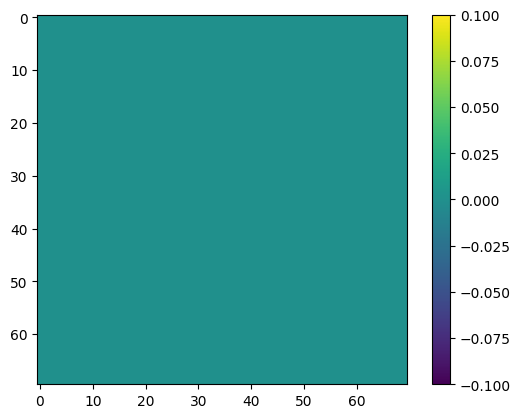

In [93]:
plt.figure()
vel_res = copy.deepcopy(vel_guess_cp)
vel_res.from_vector(vel_guess_cp.to_vector()- vel_true.to_vector())
plt.imshow(cp.asnumpy(vel_res.data))
plt.colorbar()